## Imports et Environnement

In [28]:
# On importe les bibliothèques nécessaires
import numpy as np          # Pour les opérations numériques et la gestion des Q-tables
import gymnasium as gym     # L'environnement Taxi-v3 vient de gymnasium (nouvelle version de OpenAI Gym)
import matplotlib.pyplot as plt  # Pour tracer les courbes d'apprentissage
import time                 # Pour mesurer le temps d'entraînement (coût computationnel)

In [29]:
# =============================================================================
# FONCTIONS UTILITAIRES
# =============================================================================

def epsilon_greedy(Q, state, n_actions, epsilon, rng):
    """
    Politique epsilon-greedy : avec proba epsilon on explore (action aléatoire),
    sinon on exploite (meilleure action selon Q).
    C'est le compromis exploration vs exploitation !
    """
    if rng.random() < epsilon:  # Exploration : on choisit au hasard
        return int(rng.integers(n_actions))
    return int(np.argmax(Q[state]))  # Exploitation : on prend la meilleure action connue

def moving_average(x, window=200):
    """
    Calcule la moyenne mobile pour lisser les courbes d'apprentissage.
    Ça permet de mieux voir la tendance générale sans le bruit.
    """
    x = np.asarray(x, dtype=np.float32)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

In [30]:
# =============================================================================
# ALGORITHME SARSA (State-Action-Reward-State-Action)
# =============================================================================
# SARSA est un algorithme ON-POLICY : il apprend la valeur de la politique
# qu'il suit réellement (incluant l'exploration epsilon-greedy).
#
# Règle de mise à jour :
# Q(s,a) <- Q(s,a) + alpha * [r + gamma * Q(s',a') - Q(s,a)]
#                                         ↑
#                     a' = prochaine action RÉELLEMENT prise (on-policy)
# =============================================================================

def train_sarsa(
    env_id="Taxi-v3",
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=0,
    max_steps=200,
):
    env = gym.make(env_id)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    epsilon = epsilon_start
    rewards_history = []

    # On mesure le temps d'entraînement pour le coût computationnel
    start_time = time.time()

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        action = epsilon_greedy(Q, state, n_actions, epsilon, rng)
        total_reward = 0.0

        for _ in range(max_steps):
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # SARSA : on choisit la prochaine action MAINTENANT (on-policy)
            next_action = epsilon_greedy(Q, next_state, n_actions, epsilon, rng)

            # Mise à jour TD
            td_target = reward + (0.0 if done else gamma * Q[next_state, next_action])
            Q[state, action] += alpha * (td_target - Q[state, action])

            state, action = next_state, next_action
            if done:
                break

        rewards_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (ep + 1) % 5000 == 0:
            print(f"SARSA | Episode {ep+1:>6} | eps={epsilon:.3f} | avg={np.mean(rewards_history[-1000:]):.2f}")

    training_time = time.time() - start_time
    env.close()
    return Q, rewards_history, training_time

## Lancer Entraînement

In [31]:
# Entraînement SARSA
Q_sarsa, rewards_sarsa, time_sarsa = train_sarsa(
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=42
)
print(f"\nTemps d'entraînement SARSA: {time_sarsa:.2f} secondes")

SARSA | Episode   5000 | eps=0.082 | avg=2.00
SARSA | Episode  10000 | eps=0.050 | avg=5.15
SARSA | Episode  15000 | eps=0.050 | avg=5.01
SARSA | Episode  20000 | eps=0.050 | avg=5.17

Temps d'entraînement SARSA: 6.65 secondes


## Courbes d'apprentissage

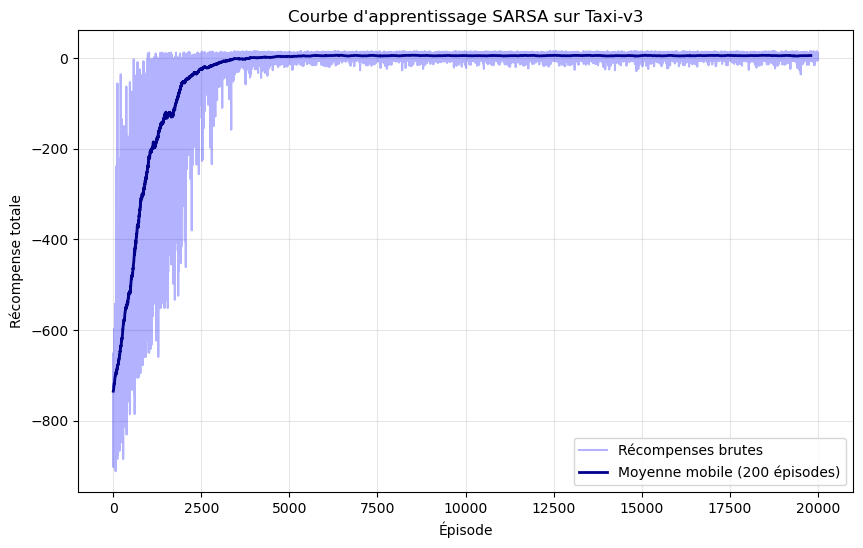

In [32]:
# Courbe d'apprentissage SARSA
# On trace les récompenses brutes (transparentes) + la moyenne mobile (ligne pleine)
plt.figure(figsize=(10, 6))
plt.plot(rewards_sarsa, alpha=0.3, color='blue', label='Récompenses brutes')
ma_sarsa = moving_average(rewards_sarsa, window=200)
plt.plot(range(len(ma_sarsa)), ma_sarsa, color='darkblue', linewidth=2, label='Moyenne mobile (200 épisodes)')
plt.xlabel("Épisode")
plt.ylabel("Récompense totale")
plt.title("Courbe d'apprentissage SARSA sur Taxi-v3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# On peut voir que l'agent commence avec des récompenses très négatives
# (il fait n'importe quoi) puis apprend progressivement à faire mieux

## Q-Learning

In [33]:
# =============================================================================
# ALGORITHME Q-LEARNING
# =============================================================================
# Q-learning est un algorithme OFF-POLICY : il apprend la politique OPTIMALE
# peu importe la politique suivie pendant l'entraînement.
#
# Règle de mise à jour :
# Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
#                                         ↑
#                     max sur toutes les actions (off-policy)
#
# DIFFÉRENCE CLÉ AVEC SARSA :
# - SARSA utilise Q(s', a') où a' est l'action RÉELLEMENT prise
# - Q-learning utilise max Q(s', a') = la MEILLEURE action possible
# =============================================================================

def train_qlearning(
    env_id="Taxi-v3",
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=0,
    max_steps=200,
):
    env = gym.make(env_id)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    epsilon = epsilon_start
    rewards_history = []

    start_time = time.time()

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        total_reward = 0.0

        for _ in range(max_steps):
            action = epsilon_greedy(Q, state, n_actions, epsilon, rng)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # Q-LEARNING : on utilise le MAX (off-policy)
            best_next_q = np.max(Q[next_state])
            td_target = reward + (0.0 if done else gamma * best_next_q)
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state
            if done:
                break

        rewards_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (ep + 1) % 5000 == 0:
            print(f"Q-Learning | Episode {ep+1:>6} | eps={epsilon:.3f} | avg={np.mean(rewards_history[-1000:]):.2f}")

    training_time = time.time() - start_time
    env.close()
    return Q, rewards_history, training_time

In [34]:
# Entraînement Q-Learning
Q_qlearn, rewards_qlearn, time_qlearn = train_qlearning(
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=42
)
print(f"\nTemps d'entraînement Q-Learning: {time_qlearn:.2f} secondes")

Q-Learning | Episode   5000 | eps=0.082 | avg=2.02
Q-Learning | Episode  10000 | eps=0.050 | avg=5.08
Q-Learning | Episode  15000 | eps=0.050 | avg=5.09
Q-Learning | Episode  20000 | eps=0.050 | avg=5.37

Temps d'entraînement Q-Learning: 7.40 secondes


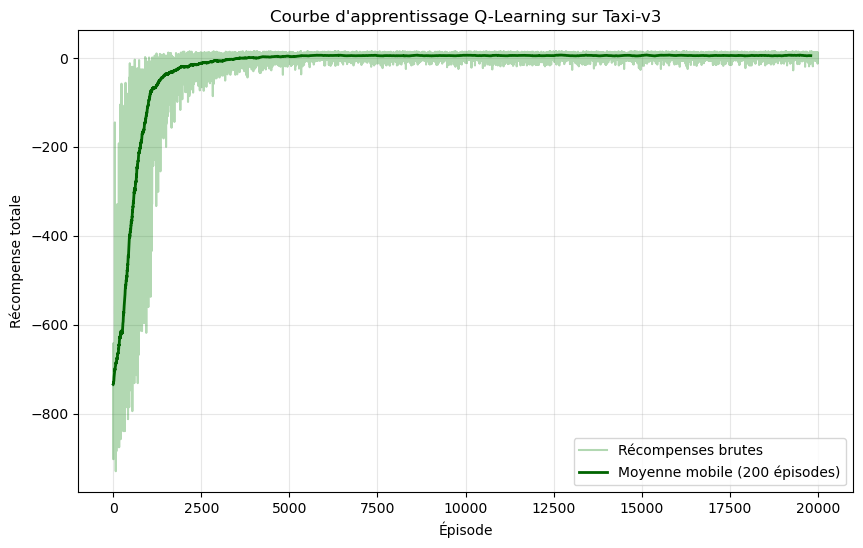

In [35]:
# Courbe d'apprentissage Q-Learning
plt.figure(figsize=(10, 6))
plt.plot(rewards_qlearn, alpha=0.3, color='green', label='Récompenses brutes')
ma_qlearn = moving_average(rewards_qlearn, window=200)
plt.plot(range(len(ma_qlearn)), ma_qlearn, color='darkgreen', linewidth=2, label='Moyenne mobile (200 épisodes)')
plt.xlabel("Épisode")
plt.ylabel("Récompense totale")
plt.title("Courbe d'apprentissage Q-Learning sur Taxi-v3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Q-learning apprend généralement plus vite que SARSA car il vise
# directement la politique optimale (off-policy)

## Expected SARSA

In [36]:
# =============================================================================
# ALGORITHME EXPECTED SARSA
# =============================================================================
# Expected SARSA est un COMPROMIS entre SARSA et Q-Learning.
# Au lieu d'utiliser Q(s',a') (SARSA) ou max Q(s',a') (Q-Learning),
# on utilise l'ESPÉRANCE de Q selon la politique epsilon-greedy.
#
# Règle de mise à jour :
# Q(s,a) <- Q(s,a) + alpha * [r + gamma * E[Q(s',a')] - Q(s,a)]
#
# où E[Q(s',a')] = (1-eps) * max_a Q(s',a) + eps * mean_a Q(s',a)
#
# AVANTAGES :
# - Moins de variance que SARSA (car on prend l'espérance)
# - Plus stable que Q-Learning dans certains cas
# - Converge vers Q-Learning quand epsilon -> 0
# =============================================================================

def train_expected_sarsa(
    env_id="Taxi-v3",
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=0,
    max_steps=200,
):
    env = gym.make(env_id)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    epsilon = epsilon_start
    rewards_history = []

    start_time = time.time()

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        total_reward = 0.0

        for _ in range(max_steps):
            action = epsilon_greedy(Q, state, n_actions, epsilon, rng)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # EXPECTED SARSA : on calcule l'espérance de Q(s', a')
            # sous la politique epsilon-greedy actuelle
            # E[Q] = (1-eps) * max(Q) + eps * mean(Q)
            expected_q = (1 - epsilon) * np.max(Q[next_state]) + \
                         epsilon * np.mean(Q[next_state])
            
            td_target = reward + (0.0 if done else gamma * expected_q)
            Q[state, action] += alpha * (td_target - Q[state, action])

            state = next_state
            if done:
                break

        rewards_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (ep + 1) % 5000 == 0:
            print(f"Expected SARSA | Episode {ep+1:>6} | eps={epsilon:.3f} | avg={np.mean(rewards_history[-1000:]):.2f}")

    training_time = time.time() - start_time
    env.close()
    return Q, rewards_history, training_time

In [37]:
# Entraînement Expected SARSA
Q_expected, rewards_expected, time_expected = train_expected_sarsa(
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=42
)
print(f"\nTemps d'entraînement Expected SARSA: {time_expected:.2f} secondes")

Expected SARSA | Episode   5000 | eps=0.082 | avg=1.69
Expected SARSA | Episode  10000 | eps=0.050 | avg=5.26
Expected SARSA | Episode  15000 | eps=0.050 | avg=5.22
Expected SARSA | Episode  20000 | eps=0.050 | avg=5.10

Temps d'entraînement Expected SARSA: 10.05 secondes


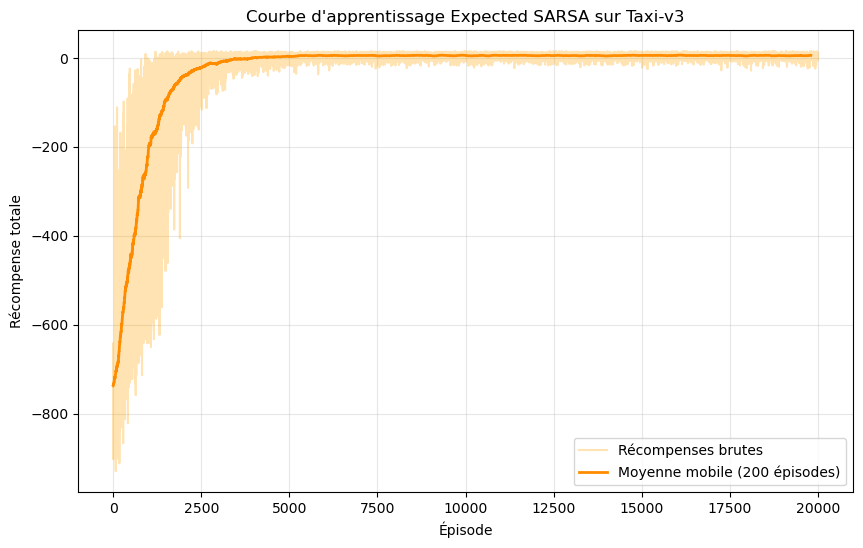

In [38]:
# Courbe d'apprentissage Expected SARSA
plt.figure(figsize=(10, 6))
plt.plot(rewards_expected, alpha=0.3, color='orange', label='Récompenses brutes')
ma_expected = moving_average(rewards_expected, window=200)
plt.plot(range(len(ma_expected)), ma_expected, color='darkorange', linewidth=2, label='Moyenne mobile (200 épisodes)')
plt.xlabel("Épisode")
plt.ylabel("Récompense totale")
plt.title("Courbe d'apprentissage Expected SARSA sur Taxi-v3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Monte Carlo

In [39]:
# =============================================================================
# ALGORITHME MONTE CARLO (First-Visit)
# =============================================================================
# Monte Carlo est FONDAMENTALEMENT différent des méthodes TD (SARSA, Q-Learning).
#
# DIFFÉRENCE CLÉ :
# - TD (Temporal Difference) : mise à jour À CHAQUE PAS (bootstrapping)
# - Monte Carlo : mise à jour SEULEMENT À LA FIN de l'épisode
#
# Monte Carlo utilise le RETOUR RÉEL (somme des récompenses jusqu'à la fin)
# au lieu d'une estimation bootstrap comme TD.
#
# Règle de mise à jour :
# Q(s,a) <- Q(s,a) + alpha * [G - Q(s,a)]
# où G = récompense totale obtenue depuis (s,a) jusqu'à la fin de l'épisode
#
# AVANTAGES :
# - Pas de biais (on utilise le vrai retour, pas une estimation)
# - Fonctionne même sans modèle de l'environnement
#
# INCONVÉNIENTS :
# - Haute variance (le retour peut beaucoup varier)
# - Doit attendre la fin de l'épisode pour apprendre
# - Ne fonctionne que pour les épisodes qui se terminent (épisodic tasks)
# =============================================================================

def train_monte_carlo(
    env_id="Taxi-v3",
    episodes=20_000,
    alpha=0.1,            # Learning rate
    gamma=0.99,           # Discount factor
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=0,
    max_steps=200,
):
    env = gym.make(env_id)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    epsilon = epsilon_start
    rewards_history = []

    start_time = time.time()

    for ep in range(episodes):
        # On stocke tout l'épisode : (state, action, reward)
        episode_trajectory = []
        
        state, info = env.reset(seed=seed + ep)
        total_reward = 0.0

        # Génération de l'épisode complet
        for _ in range(max_steps):
            action = epsilon_greedy(Q, state, n_actions, epsilon, rng)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            episode_trajectory.append((state, action, reward))
            total_reward += reward
            
            state = next_state
            if done:
                break

        # MONTE CARLO : mise à jour APRÈS l'épisode complet
        # On calcule le retour G pour chaque paire (s, a) visitée
        G = 0.0  # Retour cumulé (on remonte depuis la fin)
        visited = set()  # Pour First-Visit MC
        
        # On parcourt l'épisode À L'ENVERS pour calculer les retours
        for t in range(len(episode_trajectory) - 1, -1, -1):
            state_t, action_t, reward_t = episode_trajectory[t]
            G = gamma * G + reward_t  # Retour discounté
            
            # First-Visit : on ne met à jour que la PREMIÈRE visite de (s, a)
            if (state_t, action_t) not in visited:
                visited.add((state_t, action_t))
                # Mise à jour de Q avec le retour réel G
                Q[state_t, action_t] += alpha * (G - Q[state_t, action_t])

        rewards_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (ep + 1) % 5000 == 0:
            print(f"Monte Carlo | Episode {ep+1:>6} | eps={epsilon:.3f} | avg={np.mean(rewards_history[-1000:]):.2f}")

    training_time = time.time() - start_time
    env.close()
    return Q, rewards_history, training_time

In [40]:
# Entraînement Monte Carlo
Q_mc, rewards_mc, time_mc = train_monte_carlo(
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=42
)
print(f"\nTemps d'entraînement Monte Carlo: {time_mc:.2f} secondes")

Monte Carlo | Episode   5000 | eps=0.082 | avg=-127.05
Monte Carlo | Episode  10000 | eps=0.050 | avg=-246.32
Monte Carlo | Episode  15000 | eps=0.050 | avg=-227.43
Monte Carlo | Episode  20000 | eps=0.050 | avg=-220.43

Temps d'entraînement Monte Carlo: 26.13 secondes


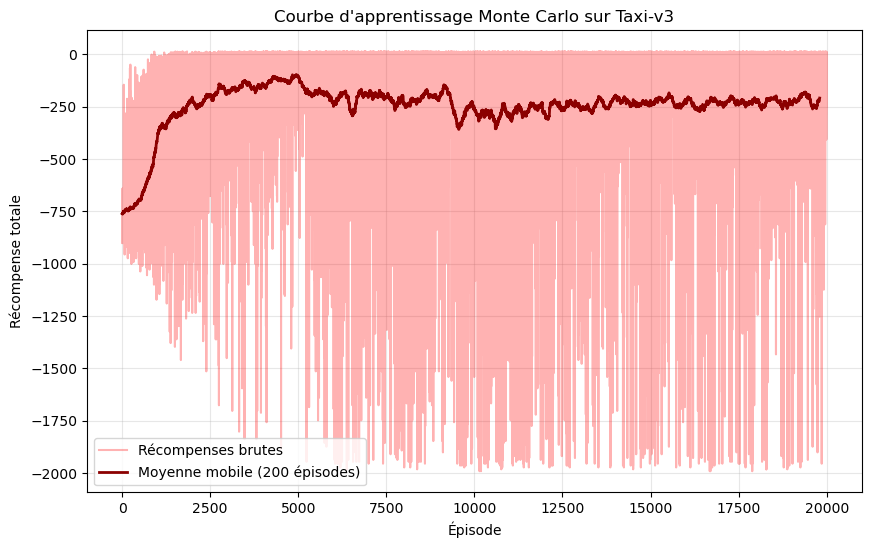

In [41]:
# Courbe d'apprentissage Monte Carlo
plt.figure(figsize=(10, 6))
plt.plot(rewards_mc, alpha=0.3, color='red', label='Récompenses brutes')
ma_mc = moving_average(rewards_mc, window=200)
plt.plot(range(len(ma_mc)), ma_mc, color='darkred', linewidth=2, label='Moyenne mobile (200 épisodes)')
plt.xlabel("Épisode")
plt.ylabel("Récompense totale")
plt.title("Courbe d'apprentissage Monte Carlo sur Taxi-v3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Double Q-Learning

In [42]:
# =============================================================================
# ALGORITHME DOUBLE Q-LEARNING
# =============================================================================
# Double Q-Learning résout le problème de SURESTIMATION de Q-Learning.
#
# PROBLÈME DE Q-LEARNING :
# max_a Q(s',a) tend à surestimer la vraie valeur car le même estimateur
# est utilisé pour sélectionner ET évaluer l'action.
#
# SOLUTION DE DOUBLE Q-LEARNING :
# On utilise DEUX Q-tables (Q_A et Q_B) :
# - Q_A sélectionne l'action : a* = argmax_a Q_A(s', a)
# - Q_B évalue cette action : Q_B(s', a*)
# Et on alterne entre mettre à jour Q_A ou Q_B à chaque pas.
#
# Cela DÉCOUPLE la sélection et l'évaluation, réduisant la surestimation.
# =============================================================================

def train_double_qlearning(
    env_id="Taxi-v3",
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=0,
    max_steps=200,
):
    env = gym.make(env_id)
    rng = np.random.default_rng(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # DEUX Q-tables au lieu d'une seule !
    Q_A = np.zeros((n_states, n_actions), dtype=np.float32)
    Q_B = np.zeros((n_states, n_actions), dtype=np.float32)

    epsilon = epsilon_start
    rewards_history = []

    start_time = time.time()

    for ep in range(episodes):
        state, info = env.reset(seed=seed + ep)
        total_reward = 0.0

        for _ in range(max_steps):
            # On utilise la SOMME des deux Q-tables pour choisir l'action
            # (meilleure estimation globale)
            Q_sum = Q_A[state] + Q_B[state]
            if rng.random() < epsilon:
                action = int(rng.integers(n_actions))
            else:
                action = int(np.argmax(Q_sum))

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # DOUBLE Q-LEARNING : on choisit aléatoirement quelle Q-table mettre à jour
            if rng.random() < 0.5:
                # Mise à jour de Q_A
                # Q_A sélectionne l'action, Q_B l'évalue
                best_action = np.argmax(Q_A[next_state])  # A choisit
                td_target = reward + (0.0 if done else gamma * Q_B[next_state, best_action])  # B évalue
                Q_A[state, action] += alpha * (td_target - Q_A[state, action])
            else:
                # Mise à jour de Q_B
                # Q_B sélectionne l'action, Q_A l'évalue
                best_action = np.argmax(Q_B[next_state])  # B choisit
                td_target = reward + (0.0 if done else gamma * Q_A[next_state, best_action])  # A évalue
                Q_B[state, action] += alpha * (td_target - Q_B[state, action])

            state = next_state
            if done:
                break

        rewards_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (ep + 1) % 5000 == 0:
            print(f"Double Q-Learning | Episode {ep+1:>6} | eps={epsilon:.3f} | avg={np.mean(rewards_history[-1000:]):.2f}")

    training_time = time.time() - start_time
    env.close()
    # On retourne la moyenne des deux Q-tables comme Q-table finale
    return (Q_A + Q_B) / 2, rewards_history, training_time

In [43]:
# Entraînement Double Q-Learning
Q_double, rewards_double, time_double = train_double_qlearning(
    episodes=20_000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    seed=42
)
print(f"\nTemps d'entraînement Double Q-Learning: {time_double:.2f} secondes")

Double Q-Learning | Episode   5000 | eps=0.082 | avg=2.01
Double Q-Learning | Episode  10000 | eps=0.050 | avg=5.32
Double Q-Learning | Episode  15000 | eps=0.050 | avg=5.04
Double Q-Learning | Episode  20000 | eps=0.050 | avg=5.00

Temps d'entraînement Double Q-Learning: 6.77 secondes


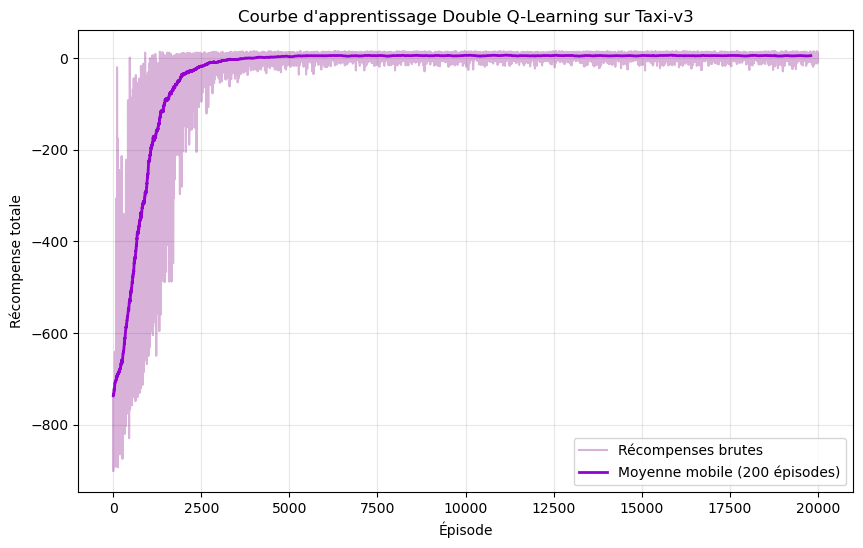

In [44]:
# Courbe d'apprentissage Double Q-Learning
plt.figure(figsize=(10, 6))
plt.plot(rewards_double, alpha=0.3, color='purple', label='Récompenses brutes')
ma_double = moving_average(rewards_double, window=200)
plt.plot(range(len(ma_double)), ma_double, color='darkviolet', linewidth=2, label='Moyenne mobile (200 épisodes)')
plt.xlabel("Épisode")
plt.ylabel("Récompense totale")
plt.title("Courbe d'apprentissage Double Q-Learning sur Taxi-v3")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Comparaison SARSA vs Q-Learning

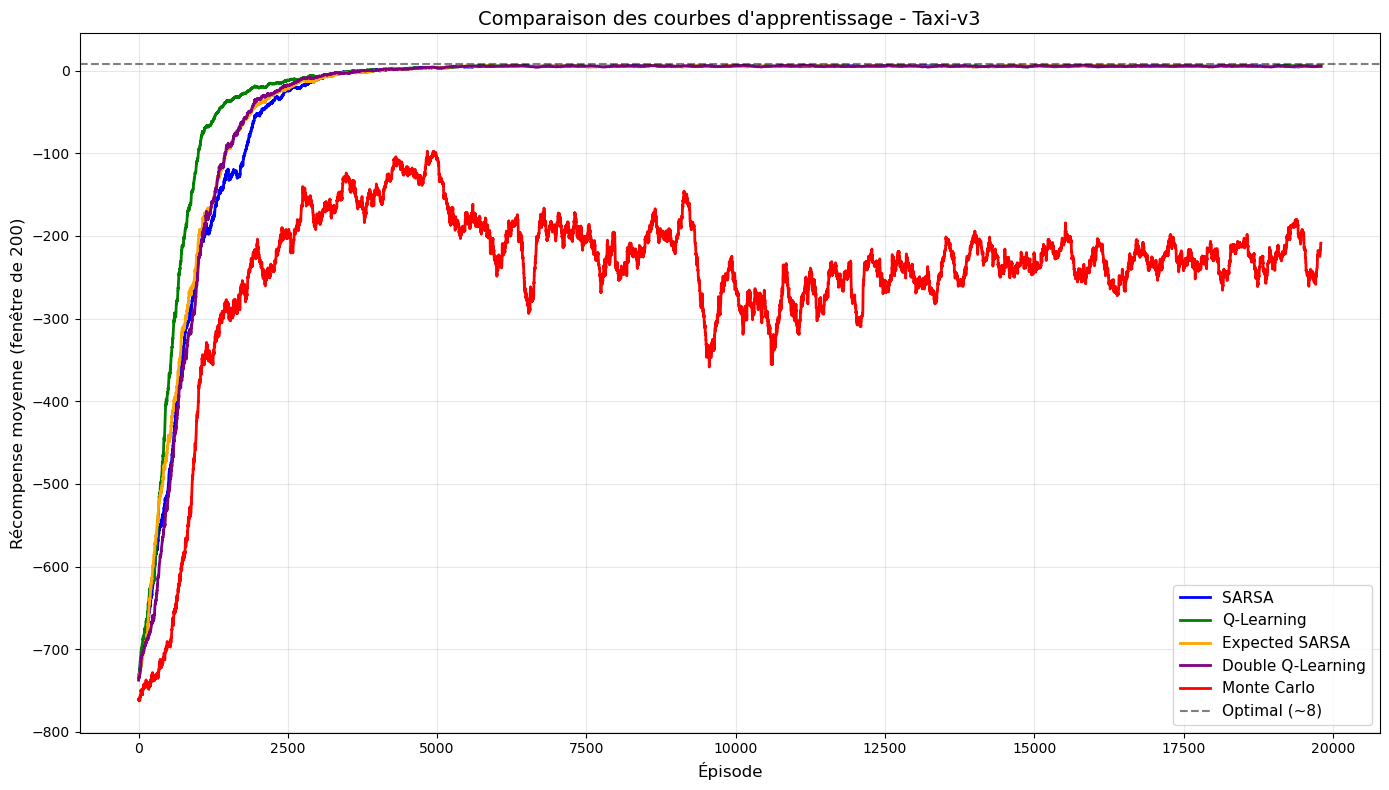

In [45]:
# =============================================================================
# COURBE COMPARATIVE DE TOUS LES ALGORITHMES
# =============================================================================

plt.figure(figsize=(14, 8))

# Calcul des moyennes mobiles pour tous les algorithmes
ma_sarsa = moving_average(rewards_sarsa, window=200)
ma_qlearn = moving_average(rewards_qlearn, window=200)
ma_expected = moving_average(rewards_expected, window=200)
ma_double = moving_average(rewards_double, window=200)
ma_mc = moving_average(rewards_mc, window=200)

# Tracé des courbes
plt.plot(range(len(ma_sarsa)), ma_sarsa, color='blue', linewidth=2, label='SARSA')
plt.plot(range(len(ma_qlearn)), ma_qlearn, color='green', linewidth=2, label='Q-Learning')
plt.plot(range(len(ma_expected)), ma_expected, color='orange', linewidth=2, label='Expected SARSA')
plt.plot(range(len(ma_double)), ma_double, color='purple', linewidth=2, label='Double Q-Learning')
plt.plot(range(len(ma_mc)), ma_mc, color='red', linewidth=2, label='Monte Carlo')

# Ligne de référence
plt.axhline(y=8, color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='Optimal (~8)')

plt.xlabel("Épisode", fontsize=12)
plt.ylabel("Récompense moyenne (fenêtre de 200)", fontsize=12)
plt.title("Comparaison des courbes d'apprentissage - Taxi-v3", fontsize=14)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Évaluation finale (politique greedy)

In [46]:
# =============================================================================
# FONCTION D'ÉVALUATION FINALE
# =============================================================================
# On évalue la politique apprise en mode GREEDY (epsilon=0, pas d'exploration)
# C'est le "score final" de chaque algorithme

def evaluate_policy(Q_table, env_id="Taxi-v3", n_episodes=100, seed=999, max_steps=200):
    """
    Évalue une politique greedy dérivée d'une Q-table.
    Retourne : score moyen, écart-type (stabilité), taux de succès
    """
    env = gym.make(env_id)
    returns = []
    successes = 0
    
    for ep in range(n_episodes):
        state, _ = env.reset(seed=seed + ep)
        total_reward = 0.0
        
        for _ in range(max_steps):
            action = int(np.argmax(Q_table[state]))  # Politique greedy
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                if reward == 20:  # Récompense de livraison réussie
                    successes += 1
                break
        
        returns.append(total_reward)
    
    env.close()
    return np.mean(returns), np.std(returns), successes / n_episodes * 100

# Évaluation de tous les algorithmes
print("Évaluation des politiques apprises (100 épisodes, greedy)...")
print("-" * 60)

eval_sarsa = evaluate_policy(Q_sarsa)
print(f"SARSA          : Score={eval_sarsa[0]:.2f} ± {eval_sarsa[1]:.2f}, Succès={eval_sarsa[2]:.0f}%")

eval_qlearn = evaluate_policy(Q_qlearn)
print(f"Q-Learning     : Score={eval_qlearn[0]:.2f} ± {eval_qlearn[1]:.2f}, Succès={eval_qlearn[2]:.0f}%")

eval_expected = evaluate_policy(Q_expected)
print(f"Expected SARSA : Score={eval_expected[0]:.2f} ± {eval_expected[1]:.2f}, Succès={eval_expected[2]:.0f}%")

eval_double = evaluate_policy(Q_double)
print(f"Double Q-Learn : Score={eval_double[0]:.2f} ± {eval_double[1]:.2f}, Succès={eval_double[2]:.0f}%")

eval_mc = evaluate_policy(Q_mc)
print(f"Monte Carlo    : Score={eval_mc[0]:.2f} ± {eval_mc[1]:.2f}, Succès={eval_mc[2]:.0f}%")

Évaluation des politiques apprises (100 épisodes, greedy)...
------------------------------------------------------------
SARSA          : Score=7.63 ± 3.00, Succès=100%
Q-Learning     : Score=7.67 ± 2.95, Succès=100%
Expected SARSA : Score=7.67 ± 2.95, Succès=100%
Double Q-Learn : Score=7.67 ± 2.95, Succès=100%
Monte Carlo    : Score=-369.81 ± 608.00, Succès=22%


## Tableau comparatif

In [47]:
# =============================================================================
# TABLEAU COMPARATIF COMPLET
# =============================================================================

def calculate_convergence_episode(rewards, threshold_ratio=0.9, window=200):
    """
    Trouve l'épisode où l'algorithme atteint threshold_ratio du score max.
    Mesure de la vitesse d'apprentissage.
    """
    ma = moving_average(rewards, window)
    max_score = np.max(ma)
    threshold = threshold_ratio * max_score
    
    for i, score in enumerate(ma):
        if score >= threshold:
            return i + window
    return len(rewards)

# Calcul de la vitesse de convergence
conv_sarsa = calculate_convergence_episode(rewards_sarsa)
conv_qlearn = calculate_convergence_episode(rewards_qlearn)
conv_expected = calculate_convergence_episode(rewards_expected)
conv_double = calculate_convergence_episode(rewards_double)
conv_mc = calculate_convergence_episode(rewards_mc)

# Affichage du tableau comparatif
print("\n" + "="*105)
print(" " * 35 + "TABLEAU COMPARATIF DES ALGORITHMES")
print("="*105)
print(f"{'Algorithme':<18} {'Score moyen':>12} {'Score final':>12} {'Stabilité':>10} {'Convergence':>12} {'Temps (s)':>10} {'Commentaires':<25}")
print(f"{'':18} {'(entraîn.)':>12} {'(greedy)':>12} {'(std)':>10} {'(épisode)':>12} {'':>10} {'':<25}")
print("-"*105)

# Données pour chaque algorithme
algorithms = [
    ("SARSA", rewards_sarsa, eval_sarsa, conv_sarsa, time_sarsa, "On-policy, prudent"),
    ("Q-Learning", rewards_qlearn, eval_qlearn, conv_qlearn, time_qlearn, "Off-policy, agressif"),
    ("Expected SARSA", rewards_expected, eval_expected, conv_expected, time_expected, "Compromis, stable"),
    ("Double Q-Learn", rewards_double, eval_double, conv_double, time_double, "Réduit surestimation"),
    ("Monte Carlo", rewards_mc, eval_mc, conv_mc, time_mc, "Pas de bootstrap, variance"),
]

for name, rewards, eval_results, conv_ep, train_time, comment in algorithms:
    mean_train = np.mean(rewards[-1000:])
    mean_final = eval_results[0]
    stability = eval_results[1]
    
    print(f"{name:<18} {mean_train:>12.2f} {mean_final:>12.2f} {stability:>10.2f} {conv_ep:>12} {train_time:>10.2f} {comment:<25}")

print("="*105)
print("\nLÉGENDE:")
print("- Score moyen (entraîn.) : Moyenne des récompenses sur les 1000 derniers épisodes d'entraînement")
print("- Score final (greedy)   : Performance en évaluation sans exploration (epsilon=0)")
print("- Stabilité (std)        : Écart-type des scores en évaluation (plus bas = plus stable)")
print("- Convergence (épisode)  : Épisode où l'algorithme atteint 90% de sa performance max")
print("- Temps (s)              : Temps d'entraînement en secondes")


                                   TABLEAU COMPARATIF DES ALGORITHMES
Algorithme          Score moyen  Score final  Stabilité  Convergence  Temps (s) Commentaires             
                     (entraîn.)     (greedy)      (std)    (épisode)                                     
---------------------------------------------------------------------------------------------------------
SARSA                      5.17         7.63       3.00         5983       6.65 On-policy, prudent       
Q-Learning                 5.37         7.67       2.95         5963       7.40 Off-policy, agressif     
Expected SARSA             5.10         7.67       2.95         6018      10.05 Compromis, stable        
Double Q-Learn             5.00         7.67       2.95         7353       6.77 Réduit surestimation     
Monte Carlo             -220.43      -369.81     608.00        20000      26.13 Pas de bootstrap, variance

LÉGENDE:
- Score moyen (entraîn.) : Moyenne des récompenses sur les 1000 dernie

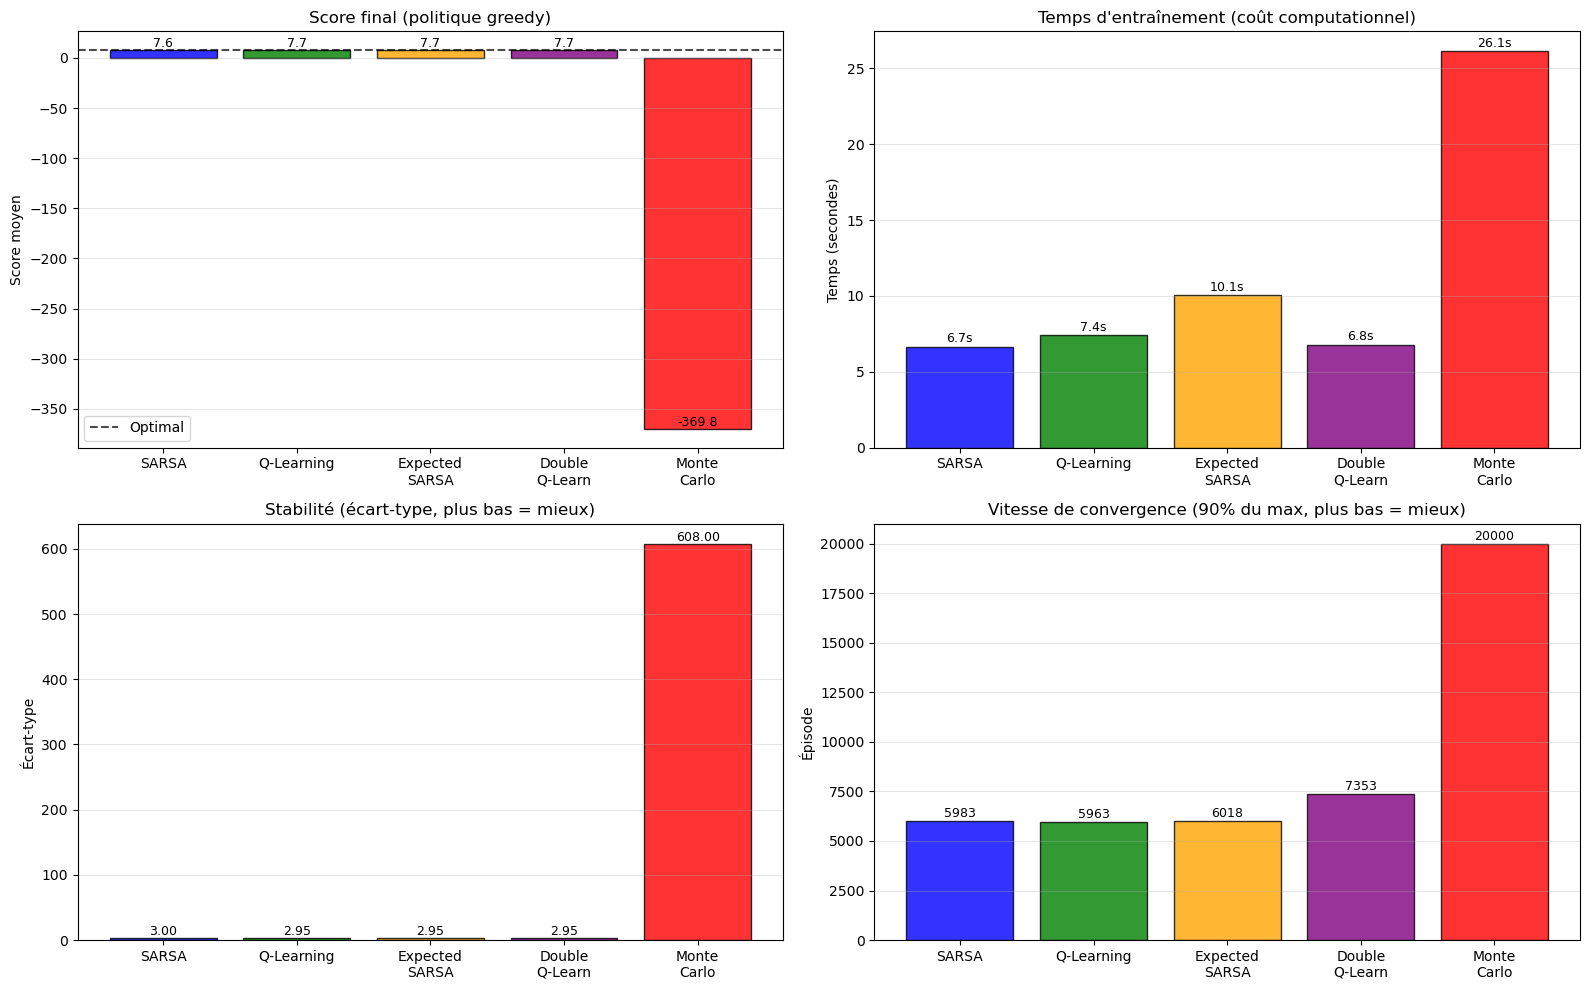

In [48]:
# =============================================================================
# GRAPHIQUE RÉCAPITULATIF EN BARRES
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

algo_names = ['SARSA', 'Q-Learning', 'Expected\nSARSA', 'Double\nQ-Learn', 'Monte\nCarlo']
colors = ['blue', 'green', 'orange', 'purple', 'red']

# 1. Score final (évaluation greedy)
ax1 = axes[0, 0]
scores_final = [eval_sarsa[0], eval_qlearn[0], eval_expected[0], eval_double[0], eval_mc[0]]
bars1 = ax1.bar(algo_names, scores_final, color=colors, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Score moyen')
ax1.set_title('Score final (politique greedy)')
ax1.axhline(y=8, color='black', linestyle='--', alpha=0.7, label='Optimal')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, scores_final):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.1f}', 
             ha='center', va='bottom', fontsize=9)

# 2. Temps d'entraînement
ax2 = axes[0, 1]
times = [time_sarsa, time_qlearn, time_expected, time_double, time_mc]
bars2 = ax2.bar(algo_names, times, color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('Temps (secondes)')
ax2.set_title("Temps d'entraînement (coût computationnel)")
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.1f}s', 
             ha='center', va='bottom', fontsize=9)

# 3. Stabilité (écart-type - plus bas = mieux)
ax3 = axes[1, 0]
stability = [eval_sarsa[1], eval_qlearn[1], eval_expected[1], eval_double[1], eval_mc[1]]
bars3 = ax3.bar(algo_names, stability, color=colors, edgecolor='black', alpha=0.8)
ax3.set_ylabel('Écart-type')
ax3.set_title('Stabilité (écart-type, plus bas = mieux)')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, stability):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=9)

# 4. Vitesse de convergence (épisode, plus bas = mieux)
ax4 = axes[1, 1]
convergence = [conv_sarsa, conv_qlearn, conv_expected, conv_double, conv_mc]
bars4 = ax4.bar(algo_names, convergence, color=colors, edgecolor='black', alpha=0.8)
ax4.set_ylabel('Épisode')
ax4.set_title('Vitesse de convergence (90% du max, plus bas = mieux)')
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars4, convergence):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{val}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()